In [1]:
import pandas as pd
import numpy as np
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Load pre-trained Word2Vec model
word2vec_model = api.load("word2vec-google-news-300")

# Function to calculate text embedding
def text_embedding(text, model):
    words = text.split()
    embeddings = []
    for word in words:
        if word in model:
            embeddings.append(model[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  # If no words found, return zero vector

# Define mapping function for sentiment labels
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

# Function to calculate sentiment polarity using TextBlob
def calculate_sentiment_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Prepare datasets function
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [3]:
# Load dataset
df = pd.read_csv('sentiment_500.csv')

# Map sentiment labels
df['sentimen'] = df['sentimen'].map(map_sentiment)

# Add text embedding as additional feature
df['text_embedding'] = df['content'].apply(lambda x: text_embedding(x, word2vec_model))

# Add sentiment polarity as additional feature
df['sentiment_polarity'] = df['content'].apply(calculate_sentiment_polarity)

# Convert text labels to numerical labels
label_encoder = LabelEncoder()
df['sentimen_encoded'] = label_encoder.fit_transform(df['sentimen'])




In [4]:
# Split data
x_train_text, x_test_text, y_train, y_test = prepare_datasets(df['content'], df['sentimen_encoded'], test_data_proportion=0.3)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_train_features = tfidf_vectorizer.fit_transform(x_train_text)
tfidf_test_features = tfidf_vectorizer.transform(x_test_text)

# Add text embedding and sentiment polarity as additional features to training and testing data
x_train_combined = np.column_stack((tfidf_train_features.toarray(), np.array([text_embedding(text, word2vec_model) for text in x_train_text]), [calculate_sentiment_polarity(text) for text in x_train_text]))
x_test_combined = np.column_stack((tfidf_test_features.toarray(), np.array([text_embedding(text, word2vec_model) for text in x_test_text]), [calculate_sentiment_polarity(text) for text in x_test_text]))

Naiye Bayes


Naive Bayes Accuracy: 0.5266666666666666
Naive Bayes Classification Report:
               precision    recall  f1-score   support

     negatif       0.50      0.63      0.56        43
      netral       0.65      0.42      0.51        57
     positif       0.47      0.56      0.51        50

    accuracy                           0.53       150
   macro avg       0.54      0.54      0.53       150
weighted avg       0.55      0.53      0.52       150



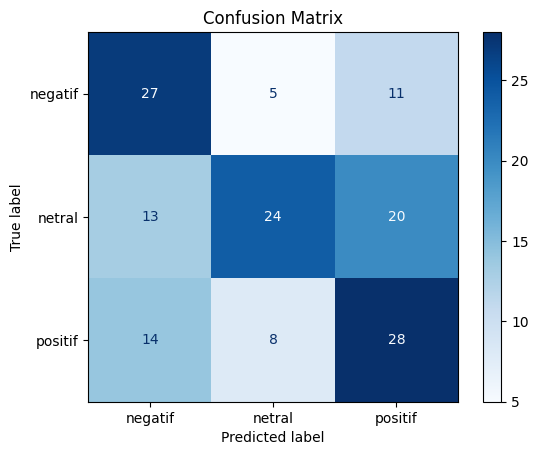

Example: calon presiden capres nomor urut 1 anies baswedan menyebut masyarakat takut mengkritik pemerintah menilai mengekang kebebasan berpendapat
True Label: negatif
Predicted Label: netral
-----------------------
Example: calon persiden capres nomor urut 1 anies baswedan menang pilpres putaran mengungkit kemenangannya putaran pilgub dki jakarta 2017 dilansir detiksumbagsel anies berkampanye bandar lampung provinsi lampung pertemuan diskusi mahasiswa bertajuk desak anies mengaku berpengalaman kontestasi pemilu berpengalaman bertarung putaran kamis 7 12 2023 anies mencontohkan kondisi pilgub dki menempatkan elektabilitasnya sandiaga uno posisi terbawah anies sandi bertarung basuki tjahaja purnama ahok djarot saiful hidayat agus harimurti yudhoyono ahy sylviana murni survei pilpres nomor urut 3 pilgub dki jakarta buktinya menang putaran insya allah menang anies memaparkan program kerjanya terpilih presiden ri salah satunya bocorkan pemerataan pembangunan transportasi massal dimana diban

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

# Train Gaussian Naive Bayes model
nb_classifier = GaussianNB()
nb_classifier.fit(x_train_combined, y_train)

# Predictions
nb_pred = nb_classifier.predict(x_test_combined)

# Accuracy
nb_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)

# Classification Report
nb_report = classification_report(y_test, nb_pred, target_names=label_encoder.classes_)
print("Naive Bayes Classification Report:\n", nb_report)

# Confusion Matrix
cm = confusion_matrix(y_test, nb_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Analisis Hasil
# Misclassification Analysis
misclassified_indices = np.where(nb_pred != y_test)[0]
misclassified_examples = x_test_text.iloc[misclassified_indices]
misclassified_labels = y_test.iloc[misclassified_indices]
misclassified_predictions = nb_pred[misclassified_indices]

# Menampilkan contoh misclassification
for i in range(len(misclassified_examples)):
    print("Example:", misclassified_examples.iloc[i])
    print("True Label:", label_encoder.inverse_transform([misclassified_labels.iloc[i]])[0])
    print("Predicted Label:", label_encoder.inverse_transform([misclassified_predictions[i]])[0])
    print("-----------------------")
